In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set()
sns.set_style("ticks")
from matplotlib.colors import LogNorm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import itertools
from scipy.stats import f_oneway, ttest_ind
import scikit_posthocs as sp
import sys

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['axes.linewidth'] = 0.4 # set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.4
matplotlib.rcParams['ytick.major.width'] = 0.4
matplotlib.rcParams['ytick.minor.width'] = 0.4
cm = 1/2.54

In [8]:
liana_data = pd.read_excel("data/human_data_first_replicates.xlsx")
msMRM12_data = pd.read_excel("data/msMRM_12_summary_df.xlsx")
msAGK25_data = pd.read_excel("data/msAGK_25_summary_df_versc15ceff.xlsx")

full_data = pd.concat([liana_data, msMRM12_data, msAGK25_data]).reset_index()

In [9]:
msAGK19_filekey = pd.read_excel("filekeys/msAGK19_filekey.xlsx")
msAGK19_filekey = msAGK19_filekey.set_index("file_name")

indel_filepath = "data/msAGK_19_ncRNA_lib.xlsx"
indel_dict = pd.read_excel(indel_filepath, sheet_name=None)
indel_data = pd.DataFrame(columns=["run_id", "edit_raw_read_count",
                             "undetermined_no_site_match_raw_read_count",
                             "wt_raw_read_count", "edit_percent",
                             "undetermined_no_site_match_percent",
                             "wt_percent"])

for run_id in indel_dict.keys():
    run_data = indel_dict[run_id]
    if not run_data.empty:
        run_data_dict = {"run_id": run_id,
                         "edit_raw_read_count": run_data.loc[run_data["Unnamed: 0"] == "edit", "raw read count"][0],
                         "undetermined_no_site_match_raw_read_count": run_data.loc[run_data["Unnamed: 0"] == "undetermined_no_site_match", "raw read count"].values[0],
                         "wt_raw_read_count": run_data.loc[run_data["Unnamed: 0"] == "wt", "raw read count"].values[0],
                         "edit_percent": run_data.loc[run_data["Unnamed: 0"] == "edit", "percent of reads"].values[0],
                         "wt_percent": run_data.loc[run_data["Unnamed: 0"] == "wt", "percent of reads"].values[0],
                         "undetermined_no_site_match_percent": run_data.loc[run_data["Unnamed: 0"] == "undetermined_no_site_match",
                                                                            "percent of reads"].values[0]}
        indel_data = pd.concat([indel_data, pd.DataFrame([run_data_dict])], ignore_index=True)
        
msAGK23_filekey = pd.read_excel("filekeys/msAGK23_filekey.xlsx")
msAGK23_filekey = msAGK23_filekey.set_index("file_name")

msAGK23_dict = pd.read_excel("data/KDC160_R4.xlsx", sheet_name=None)
for run_id in msAGK23_dict.keys():
    run_data = msAGK23_dict[run_id]
    if not run_data.empty:
        run_data_dict = {"run_id": run_id,
                         "edit_raw_read_count": run_data.loc[run_data["Unnamed: 0"] == "edit", "raw read count"][0],
                         "undetermined_no_site_match_raw_read_count": run_data.loc[run_data["Unnamed: 0"] == "undetermined_no_site_match", "raw read count"].values[0],
                         "wt_raw_read_count": run_data.loc[run_data["Unnamed: 0"] == "wt", "raw read count"].values[0],
                         "edit_percent": run_data.loc[run_data["Unnamed: 0"] == "edit", "percent of reads"].values[0],
                         "wt_percent": run_data.loc[run_data["Unnamed: 0"] == "wt", "percent of reads"].values[0],
                         "undetermined_no_site_match_percent": run_data.loc[run_data["Unnamed: 0"] == "undetermined_no_site_match",
                                                                            "percent of reads"].values[0]}
        indel_data = pd.concat([indel_data, pd.DataFrame([run_data_dict])], ignore_index=True)
        
indel_data_reindex = indel_data.set_index("run_id")
indel_filekey = pd.concat([msAGK19_filekey, msAGK23_filekey])
indel_data_reindex["plasmid"] = indel_filekey["plasmid"]
indel_data = indel_data_reindex

In [10]:
construct_key = pd.read_excel("filekeys/human_val_construct_key.xlsx")

## FIG 4b-e:

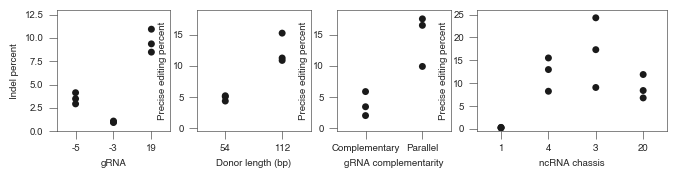

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20*cm, 4*cm), gridspec_kw={'width_ratios': [3, 3, 3, 5]})

pam_construct_key = construct_key.loc[construct_key["Experiment"] == "PAM", :]
constructs = pam_construct_key["plasmid"].unique()
masked_data = indel_data.loc[indel_data["plasmid"].isin(constructs), :].set_index("plasmid").join(pam_construct_key.set_index("plasmid"))
eco1_data = masked_data.loc[masked_data["Retron"] == "-Eco1", :]

sns.stripplot(data=eco1_data,
              x="PAM",
              y="undetermined_no_site_match_percent",
              color="k",
              s=5,
              ax=ax[0],
              jitter=False)
# ax.set_ylim([0.05, 2])
ax[0].set_ylabel("Indel percent", font="Helvetica", fontsize=7)
ax[0].set_xlabel("gRNA", fontsize=7, font="Helvetica")
ax[0].tick_params(axis='both', which='major', labelsize=7)
ax[0].set_ylim([0, 13])

paired_samples_sequencing_run = ["msKDC-08", "msMRM_12"]
length_construct_key = construct_key.loc[construct_key["Experiment"] == "Length", :]
constructs = length_construct_key["plasmid"].unique()
masked_data = full_data.loc[full_data["plasmid"].isin(constructs), :]
run_indices_1 = [x for x in masked_data.index if "msKDC-08" in masked_data.loc[x, "run_id"]]
run_indices_2 = [x for x in masked_data.index if "msMRM_12" in masked_data.loc[x, "run_id"]]
run_indices = run_indices_1 + run_indices_2
masked_data = masked_data.loc[run_indices, :]
masked_data = masked_data.set_index("plasmid").join(length_construct_key.set_index("plasmid"))

# donor length
ax[1].set_clip_on(False)
sns.stripplot(data=masked_data,
              x="Length",
              y="edit_pct",
              color="k",
              s=5,
              ax=ax[1],
              order=[54.0, 112.0],
              jitter=False)
ax[1].set_ylabel("Precise editing percent", font="Helvetica", fontsize=7)
ax[1].set_xlabel("Donor length (bp)", fontsize=7, font="Helvetica")
ax[1].tick_params(axis='both', which='major', labelsize=7)
ax[1].set_xticklabels([54,  112], fontsize=7, font="Helvetica")
ax[1].set_ylim([-0.5, 19])

pairing_information = pd.read_excel("filekeys/Pairing_Samples_For_T.xlsx")
paired_samples_sequencing_run = ["msKDC-08", "msMRM_12"]
dir_construct_key = construct_key.loc[construct_key["Experiment"] == "Direction", :]
dir_construct_key = dir_construct_key.loc[dir_construct_key["PAM"] == 19, :]
constructs = dir_construct_key["plasmid"].unique()
masked_data = full_data.loc[full_data["plasmid"].isin(constructs), :]
run_indices_1 = [x for x in masked_data.index if "msKDC-08" in masked_data.loc[x, "run_id"]]
run_indices_2 = [x for x in masked_data.index if "msMRM_12" in masked_data.loc[x, "run_id"]]
run_indices = run_indices_1 + run_indices_2
masked_data = masked_data.loc[run_indices, :]
masked_data = masked_data.set_index("plasmid").join(dir_construct_key.set_index("plasmid"))
masked_data = masked_data.loc[masked_data["run_id"].isin(pairing_information["run_id"]), :]

# donor length
ax[2].set_clip_on(False)
sns.stripplot(data=masked_data,
              x="parallel_or_anti",
              y="edit_pct",
              color="k",
              s=5,
              ax=ax[2],
              order=["Complementary", "Parallel"],
              jitter=False)
# ax.set_ylim([0.05, 2])
ax[2].set_ylabel("Precise editing percent", font="Helvetica", fontsize=7)
ax[2].set_xlabel("gRNA complementarity", fontsize=7, font="Helvetica")
ax[2].tick_params(axis='both', which='major', labelsize=7)
ax[2].set_xticklabels(["Complementary", "Parallel"], fontsize=7, font="Helvetica")
ax[2].set_ylim([-0.5, 19])

paired_samples_sequencing_run = ["msAGK_25"]
chassis_construct_key = construct_key.loc[construct_key["Experiment"] == "Chassis", :]
constructs = chassis_construct_key["plasmid"].unique()
masked_data = full_data.loc[full_data["plasmid"].isin(constructs), :]
run_indices = [x for x in masked_data.index if "msAGK_25" in masked_data.loc[x, "run_id"]]
masked_data = masked_data.loc[run_indices, :]
masked_data = masked_data.set_index("plasmid").join(chassis_construct_key.set_index("plasmid"))

# donor length
ax[3].set_clip_on(False)
sns.stripplot(data=masked_data,
              x="Chassis",
              y="edit_pct",
              color="k",
              s=5,
              ax=ax[3],
              order=[1, 4, 3, 20],
              jitter=False)
ax[3].set_ylim([-0.5, 26])
ax[3].set_ylabel("Precise editing percent", font="Helvetica", fontsize=7)
ax[3].set_xlabel("ncRNA chassis", fontsize=7, font="Helvetica")
ax[3].tick_params(axis='both', which='major', labelsize=7)
ax[3].set_xticklabels([1, 4, 3, 20], fontsize=7, font="Helvetica")
pass
plt.savefig("PUB_human_guide_length_dir_chassis_comp.svg", transparent=True, bbox_inches="tight")

## STATISTICS FOR FIG 4b-d:
- 4e: One-way ANOVA with Dunnett's post-hoc comparing to wild-type chassis was done in GraphPad because Conda cannot update scipy to the version with the Dunnett's test
- 4g: One-way ANOVA with Dunnett's post-hoc comparing to central edit and cut site was done in GraphPad because Conda cannot update scipy to the version with the Dunnett's test

In [25]:
# 4b: one-way ANOVA, bonferroni corrected to compare all-against-all
pam_construct_key = construct_key.loc[construct_key["Experiment"] == "PAM", :]
constructs = pam_construct_key["plasmid"].unique()
masked_data = indel_data.loc[indel_data["plasmid"].isin(constructs), :].set_index("plasmid").join(pam_construct_key.set_index("plasmid"))
eco1_data = masked_data.loc[masked_data["Retron"] == "-Eco1", :].reset_index()[["plasmid", "undetermined_no_site_match_percent"]]

model = ols('undetermined_no_site_match_percent ~ C(plasmid)', data=eco1_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA results:")
print(anova_table)

# Perform Bonferroni post-hoc test
group_combinations = list(itertools.combinations(eco1_data['plasmid'].unique(), 2))
p_values = []
for group1, group2 in group_combinations:
    group1_data = eco1_data[eco1_data['plasmid'] == group1]['undetermined_no_site_match_percent']
    group2_data = eco1_data[eco1_data['plasmid'] == group2]['undetermined_no_site_match_percent']
    _, p_value = ttest_ind(group1_data, group2_data)
    p_values.append((group1, group2, p_value))

# Bonferroni correction
bonferroni_alpha = 0.05 / len(p_values)
significant_comparisons = [(g1, g2, p) for g1, g2, p in p_values if p < bonferroni_alpha]

print("\nBonferroni post-hoc test results:")
for group1, group2, p_value in significant_comparisons:
    print(f"Comparison {group1} vs {group2}: p-value = {p_value}")

if not significant_comparisons:
    print("No significant differences found with Bonferroni correction.")

ANOVA results:
                sum_sq   df         F    PR(>F)
C(plasmid)  117.037409  2.0  91.61056  0.000032
Residual      3.832661  6.0       NaN       NaN

Bonferroni post-hoc test results:
Comparison 156 vs 158: p-value = 0.0019915254295710025
Comparison 156 vs 160: p-value = 0.00028321861649251335
Comparison 158 vs 160: p-value = 0.0015929235097827722


In [58]:
# 4c: paired t-test
pairing_information = pd.read_excel("filekeys/Pairing_Samples_For_T.xlsx")

paired_samples_sequencing_run = ["msKDC-08", "msMRM_12"]
length_construct_key = construct_key.loc[construct_key["Experiment"] == "Length", :]
constructs = length_construct_key["plasmid"].unique()
masked_data = full_data.loc[full_data["plasmid"].isin(constructs), :]
run_indices_1 = [x for x in masked_data.index if "msKDC-08" in masked_data.loc[x, "run_id"]]
run_indices_2 = [x for x in masked_data.index if "msMRM_12" in masked_data.loc[x, "run_id"]]
run_indices = run_indices_1 + run_indices_2
masked_data = masked_data.loc[run_indices, :]
masked_data = masked_data.set_index("plasmid").join(length_construct_key.set_index("plasmid"))

plasmid_42 = []
plasmid_43 = []

for replicate in np.unique(pairing_information["Replicate"]):
    replicate_df = pairing_information.loc[pairing_information["Replicate"] == replicate, :]
    replicate_df = replicate_df.loc[replicate_df["plasmid"].isin(constructs), :]
    run_id_42 = replicate_df.loc[replicate_df["plasmid"] == 42, "run_id"].iloc[0]
    plasmid_42.append(masked_data.loc[masked_data["run_id"] == run_id_42, "edit_pct"].iloc[0])
    run_id_43 = replicate_df.loc[replicate_df["plasmid"] == 43, "run_id"].iloc[0]
    plasmid_43.append(masked_data.loc[masked_data["run_id"] == run_id_43, "edit_pct"].iloc[0])
    
t_stat, p_value = stats.ttest_rel(plasmid_42, plasmid_43)

print(f"Paired T-Test Results:\nT-Statistic: {t_stat}\nP-Value: {p_value}")

Paired T-Test Results:
T-Statistic: -6.160695494959667
P-Value: 0.025349988194913537


In [69]:
# 4d: paired t-test
pairing_information = pd.read_excel("filekeys/Pairing_Samples_For_T.xlsx")

paired_samples_sequencing_run = ["msKDC-08", "msMRM_12"]
dir_construct_key = construct_key.loc[construct_key["Experiment"] == "Direction", :]
dir_construct_key = dir_construct_key.loc[dir_construct_key["PAM"] == 19, :]
constructs = dir_construct_key["plasmid"].unique()
masked_data = full_data.loc[full_data["plasmid"].isin(constructs), :]
run_indices_1 = [x for x in masked_data.index if "msKDC-08" in masked_data.loc[x, "run_id"]]
run_indices_2 = [x for x in masked_data.index if "msMRM_12" in masked_data.loc[x, "run_id"]]
run_indices = run_indices_1 + run_indices_2
masked_data = masked_data.loc[run_indices, :]
masked_data = masked_data.set_index("plasmid").join(dir_construct_key.set_index("plasmid"))

plasmid_45 = []
plasmid_50 = []

for replicate in np.unique(pairing_information["Replicate"]):
    replicate_df = pairing_information.loc[pairing_information["Replicate"] == replicate, :]
    replicate_df = replicate_df.loc[replicate_df["plasmid"].isin(constructs), :]
    run_id_45 = replicate_df.loc[replicate_df["plasmid"] == 45, "run_id"].iloc[0]
    plasmid_45.append(masked_data.loc[masked_data["run_id"] == run_id_45, "edit_pct"].iloc[0])
    run_id_50 = replicate_df.loc[replicate_df["plasmid"] == 50, "run_id"].iloc[0]
    plasmid_50.append(masked_data.loc[masked_data["run_id"] == run_id_50, "edit_pct"].iloc[0])
    
t_stat, p_value = stats.ttest_rel(plasmid_45, plasmid_50)

print(f"Paired T-Test Results:\nT-Statistic: {t_stat}\nP-Value: {p_value}")

Paired T-Test Results:
T-Statistic: -4.632837946260035
P-Value: 0.04356908802723038


## FIG 4g:

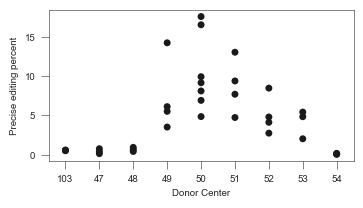

In [13]:
fig, ax = plt.subplots(figsize=(10*cm, 5*cm))

center_construct_key = construct_key.loc[construct_key["Experiment"] == "Donor Center", :]
constructs = center_construct_key["plasmid"].unique()
masked_data = full_data.loc[full_data["plasmid"].isin(constructs), :].set_index("plasmid").join(center_construct_key.set_index("plasmid")).reset_index()
masked_data.to_excel("human_donor_center_data_graphpad.xlsx")

sns.stripplot(data=masked_data,
              x="plasmid",
              y="edit_pct",
              color="k",
              s=5,
              ax=ax,
              jitter=False,
              order=[103, 47, 48,
                     49, 50, 51,
                     52, 53, 54])
# ax.set_ylim([0.05, 2])
ax.set_ylabel("Precise editing percent", font="Helvetica", fontsize=7)
ax.set_xlabel("Donor Center", fontsize=7, font="Helvetica")
ax.tick_params(axis='both', which='major', labelsize=7)
pass
# plt.savefig("PUB_human_center.svg", transparent=True, bbox_inches="tight")